In [1]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator
from scipy.signal.windows import tukey
from scipy.signal import hilbert

from matplotlib.colors import Normalize

from time import time
from timuscle.dataio import verasonics_loadtrackrf, putdictasHDF5

In [2]:
with open("cupy_module.cu", mode='r') as fp: raw_module = fp.read()

module = cp.RawModule(code=raw_module)

das_bmode_cubic = module.get_function("das_bmode_cubic")

xInfo = np.dtype([('x0', np.float32),('dx', np.float32),('nx', np.int32)])
RFInfo = np.dtype([('ntx', np.int32),('nrx', np.int32),('ndim', np.int32),('tInfo', xInfo)])

In [ ]:
datapath = "/fastrs/ultrasound/TIMuscle/InVivo/20230519_P006/acq_05_kf_43_vl_L/RawData/"
datapath = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_1_flex_90_musc_vl/RawData/"

rf, dims, rfpar = verasonics_loadtrackrf(datapath)

print(rf.shape, dims['steer_deg'])

xele = dims['xele_m']
steers = dims['steer_deg']
t = dims['t_sec']

(36, 128, 89, 3, 1536) [-3.  0.  3.]


In [4]:
c0 = 1540
r0 = 10

origtx = cp.ascontiguousarray(cp.array([[xele[-1] if steer <= 0 else xele[0] for steer in steers], np.zeros(steers.shape)], dtype=np.float32).T, dtype=cp.float32)

# calculate point source location to approximate plane waves
ovectx = cp.ascontiguousarray(-r0 * cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

# calculate normal vector of point source
nvectx = cp.ascontiguousarray(cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

t0tx = -cp.linalg.norm(origtx - ovectx, axis=-1)/c0

dof = cp.zeros(len(t0tx), dtype=np.float32)

# calculate acceptance angle for plane wave source approximated as a point
dxo = origtx - ovectx
alatx = cp.arccos(cp.abs(cp.sum(dxo * nvectx, axis=-1)) / cp.linalg.norm(dxo, axis=-1))

print(t0tx.dtype)

ovecrx = cp.ascontiguousarray(cp.array([xele, np.zeros(len(xele))]).T, dtype=np.float32)
nvecrx = cp.ascontiguousarray(cp.array([np.zeros(len(xele)), np.ones(len(xele))]).T, dtype=np.float32)
alarx = np.arctan2(1,2) * cp.ones(len(xele), dtype=np.float32)

rfinfo = np.zeros(1, dtype=RFInfo)
rfinfo['ntx'] = 1#len(steers)
rfinfo['nrx'] = len(xele)
rfinfo['ndim'] = 2
rfinfo['tInfo']['x0'] = t[0]
rfinfo['tInfo']['dx'] = t[1] - t[0]
rfinfo['tInfo']['nx'] = len(t)

print(rfinfo)

xout = 1E-3*np.linspace(-18, 18, 5 * 2 * 18 + 1)
zout = 1E-3*np.arange(1, 40, 0.15/4)
Px, Pz = np.meshgrid(xout, zout, indexing='ij')
pvec = cp.ascontiguousarray(cp.array([Px, Pz]).transpose(2, 1, 0), dtype=np.float32)
print(rf.shape)
# exit()

float32
[(1, 128, 2, (9.6e-07, 4.8e-08, 1536))]
(36, 128, 89, 3, 1536)


In [5]:
pvec.shape

(1040, 181, 2)

In [6]:
irot = 14

print("Starting beamforming")
tstart = time()

t0copy = time()
allrf = cp.ascontiguousarray(cp.array(rf[irot,:,:,:,:]).transpose(1, 2, 0, 3), dtype=np.float32)
allrf *= cp.array(tukey(allrf.shape[-1], alpha=0.25))[None, None, None, :]
t1copy = time()
print(f"  Copy time: {(t1copy-t0copy)*1E3} ms")
pout = cp.zeros((rf.shape[2], rf.shape[3], len(zout), len(xout)), dtype=np.float32)

t0rot = time()
for iim in range(rf.shape[2]):
    for istr in range(3):
        params = (
            rfinfo,
            allrf[iim, istr:istr+1],
            ovectx[istr:istr+1],
            nvectx[istr:istr+1],
            t0tx[istr:istr+1],
            alatx[istr:istr+1],
            dof[istr:istr+1],
            ovecrx,
            nvecrx,
            alarx,
            np.float32(c0),
            np.int32(pout[0,0].size),
            pvec,
            pout[iim,istr]
        )

        das_bmode_cubic((256,370,1), (256,1,1), params)
t1rot = time()

print("  ", irot, " ", (t1rot - t0rot)*1E3, " ms")

demod = None
window = None
for ipsub, psub in enumerate(pout):
    PSUB = cp.fft.rfft(psub, axis=1)
    if ipsub == 0: 
        demod = cp.zeros((pout.shape[0], *PSUB.shape), dtype=np.complex64)
        window = cp.array(tukey(demod.shape[2], 0.25)[None,:,None], dtype=np.complex64)

    PSUB *= window
    demod[ipsub] = cp.fft.ifft(cp.fft.ifftshift(PSUB, axes=1), axis=1)

dzout = zout[1] - zout[0]
dznew = dzout * pout.shape[2] / demod.shape[2]
znew  = zout[0] + dznew * np.arange(demod.shape[2])

demodavg = cp.mean(demod, axis=1)

num = demodavg[1:].real * demodavg[:-1].imag - demodavg[1:].imag * demodavg[:-1].real
den = demodavg[1:].real * demodavg[:-1].real + demodavg[1:].imag * demodavg[:-1].imag

nk = 1
kern = cp.zeros(demodavg.shape[1], dtype=np.float32)
kern[:nk//2]  = 1/nk
kern[-nk//2:] = 1/nk
KERN = cp.fft.rfft(kern, n=demod.shape[2])[None,:,None]

num = cp.fft.irfft(KERN * cp.fft.rfft(num, axis=1), axis=1)
den = cp.fft.irfft(KERN * cp.fft.rfft(den, axis=1), axis=1)

pmscale = (c0/2) * 1E6 / (2 * np.pi * 5.2E6)
pm = pmscale * cp.arctan2(num, den) / 0.3

t0trans = time()
pmout = cp.asnumpy(pm)
t1trans = time()
print("  tansfer out: ", (t1trans-t0trans)*1E3, " ms")
del pout, allrf#, demod

tstop = time()

print(f"Done beamforming, {1E3*(tstop-tstart)} ms")

Starting beamforming
  Copy time: 1754.6188831329346 ms
   14   22.576332092285156  ms
  tansfer out:  10.829687118530273  ms
Done beamforming, 2013.7674808502197 ms


In [7]:
demod_np = cp.asnumpy(demod)

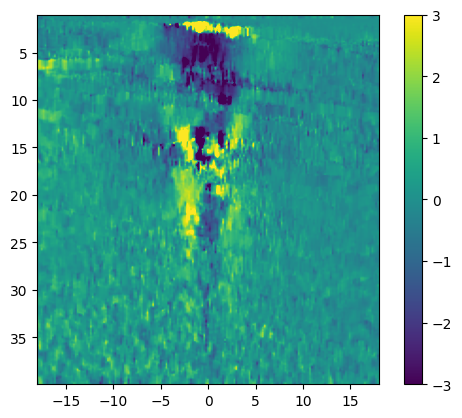

In [8]:
IQ = np.mean(demod_np, axis=1)

from dispest import calc_kasai

extent = 1E3 * np.array([xout[0], xout[-1], zout[-1], zout[0]])

pm = calc_kasai(IQ.real, IQ.imag, taxis=0, kaxis=1, fd=5.2E6, ksize=12, mode='differential')/0.3

plt.figure()
plt.imshow(pm[10,:,:], vmin=-3, vmax=3, extent=extent)
plt.colorbar()
plt.show()

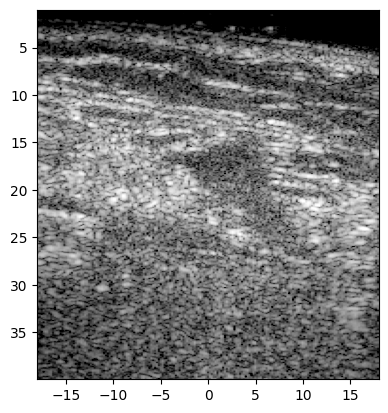

In [9]:
env = np.abs(np.mean(demod_np[0], axis=0))
logged = 20 * np.log10(env/np.percentile(env, 99))

extent = 1E3 * np.array([xout[0], xout[-1], zout[-1], zout[0]])

plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=extent)
plt.show()

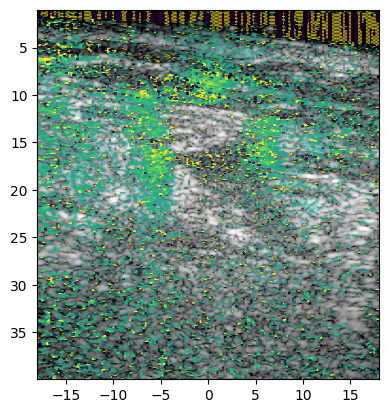

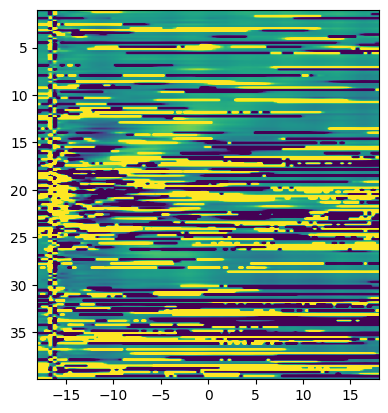

In [10]:
itsel = 30
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=extent)
plt.imshow(pmout[itsel], vmin=-3, vmax=3, cmap='viridis', extent=extent, alpha=Normalize(0.01, 0.5, clip=True)(pmout[itsel]))
plt.show()

ex_tlat = np.array([t[0], t[-1], xout[-1], xout[0]])
iaxmin = np.argmin(np.abs(znew - 15E-3))
iaxmax = np.argmin(np.abs(znew - 18E-3))
plt.figure()
plt.imshow(np.mean(pmout[:,iaxmin:iaxmax], axis=1).T, vmin=-3, vmax=3, cmap='viridis', extent=extent)
plt.show()

# Full rotational processing

In [11]:
c0 = 1540
r0 = 10

zmin = 17.5E-3
zmax = 25E-3

itmin = np.argmin(np.abs(t - 2*zmin/c0))
itmax = np.argmin(np.abs(t - 2*np.hypot(np.ptp(xele), zmax)/c0))
itmin, itmax

(453, 1207)

In [12]:
origtx = cp.ascontiguousarray(cp.array([[xele[-1] if steer <= 0 else xele[0] for steer in steers], np.zeros(steers.shape)], dtype=np.float32).T, dtype=cp.float32)

# calculate point source location to approximate plane waves
ovectx = cp.ascontiguousarray(-r0 * cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

# calculate normal vector of point source
nvectx = cp.ascontiguousarray(cp.array([np.sin(np.radians(steers)), np.cos(np.radians(steers))]).T, dtype=np.float32)

t0tx = -cp.linalg.norm(origtx - ovectx, axis=-1)/c0

dof = cp.zeros(len(t0tx), dtype=np.float32)

# calculate acceptance angle for plane wave source approximated as a point
dxo = origtx - ovectx
alatx = cp.arccos(cp.abs(cp.sum(dxo * nvectx, axis=-1)) / cp.linalg.norm(dxo, axis=-1))

print(t0tx.dtype)

ovecrx = cp.ascontiguousarray(cp.array([xele, np.zeros(len(xele))]).T, dtype=np.float32)
nvecrx = cp.ascontiguousarray(cp.array([np.zeros(len(xele)), np.ones(len(xele))]).T, dtype=np.float32)
alarx = np.arctan2(1,2) * cp.ones(len(xele), dtype=np.float32)

rfinfo = np.zeros(1, dtype=RFInfo)
rfinfo['ntx'] = len(steers)
rfinfo['nrx'] = len(xele)
rfinfo['ndim'] = 2
rfinfo['tInfo']['x0'] = t[itmin]
rfinfo['tInfo']['dx'] = t[1] - t[0]
rfinfo['tInfo']['nx'] = len(t[itmin:itmax])

print(rfinfo)

xout = 1E-3*np.linspace(-18, 18, 151)
zout = np.arange(zmin, zmax, 0.15E-3/4)
Px, Pz = np.meshgrid(xout, zout, indexing='ij')
pvec = cp.ascontiguousarray(cp.array([Px, Pz]).transpose(2, 1, 0), dtype=np.float32)
print(rf.shape)
# exit()

float32
[(3, 128, 2, (2.2704e-05, 4.8e-08, 754))]
(36, 128, 89, 3, 1536)


In [13]:
print("Starting beamforming")
tstart = time()

t0copy = time()
allrf = cp.ascontiguousarray(cp.array(rf[:,:,:,:,itmin:itmax]).transpose(0, 2, 3, 1, 4), dtype=np.float32)
allrf *= cp.array(tukey(allrf.shape[-1], alpha=0.25))[None, None, None, None, :]

print(allrf.shape)
t1copy = time()
print(f"  Copy time: {(t1copy-t0copy)*1E3} ms")
pout = cp.zeros((allrf.shape[0], allrf.shape[1], len(zout), len(xout)), dtype=np.float32)

t0rot = time()
for irot in range(rf.shape[0]):
    for iim in range(allrf.shape[1]):
        params = (
            rfinfo,
            allrf[irot,iim],
            ovectx,
            nvectx,
            t0tx,
            alatx,
            dof,
            ovecrx,
            nvecrx,
            alarx,
            np.float32(c0),
            np.int32(pout[0,0].size),
            pvec,
            pout[irot,iim]
        )

        das_bmode_cubic((64,370,1), (1024,1,1), params)
t1rot = time()

print("  ", irot, " ", (t1rot - t0rot)*1E3, " ms")

del allrf

demod = None
window = None
for ipsub, psub in enumerate(pout):
    if ipsub == 0: 
        PSUB = cp.fft.rfft(psub, axis=1)
        demod = cp.zeros((pout.shape[0], *PSUB.shape), dtype=np.complex64)
        win_freq = cp.array(tukey(PSUB.shape[1], 0.25)[None,:,None], dtype=np.complex64)
        win_time = cp.array(tukey(psub.shape[1], 0.5)[None,:,None], dtype=np.float32)
    

    PSUB = win_freq * cp.fft.rfft(psub * win_time, axis=1)
    demod[ipsub] = cp.fft.ifft(cp.fft.ifftshift(PSUB, axes=1), axis=1)

dzout = zout[1] - zout[0]
dznew = dzout * pout.shape[2] / demod.shape[2]
znew  = zout[0] + dznew * np.arange(demod.shape[2])

del pout, psub

num = demod[:,1:].real * demod[:,:-1].imag - demod[:,1:].imag * demod[:,:-1].real
den = demod[:,1:].real * demod[:,:-1].real + demod[:,1:].imag * demod[:,:-1].imag

nk = 24
kern = cp.zeros(demod.shape[2], dtype=np.float32)
kern[:nk//2]  = 1/nk
kern[-nk//2:] = 1/nk
KERN = cp.fft.rfft(kern, n=demod.shape[2])[None,None,:,None]

num = cp.fft.irfft(KERN * cp.fft.rfft(num, axis=2), axis=2)
den = cp.fft.irfft(KERN * cp.fft.rfft(den, axis=2), axis=2)

pmscale = (c0/2) * 1E6 / (2 * np.pi * 5.2E6)
pm = pmscale * cp.arctan2(num, den) / 0.3

t0trans = time()
pmout = cp.asnumpy(pm)
demodout = cp.asnumpy(demod[:,0,:,:])
demodall = cp.asnumpy(demod)
t1trans = time()
print("  tansfer out: ", (t1trans-t0trans)*1E3, " ms")
del demod, num, den, pm
tstop = time()

print(f"Done beamforming, {1E3*(tstop-tstart)} ms")

Starting beamforming
(36, 89, 3, 128, 754)
  Copy time: 38647.00722694397 ms
   35   1394.6986198425293  ms
  tansfer out:  193.13287734985352  ms
Done beamforming, 40906.02254867554 ms


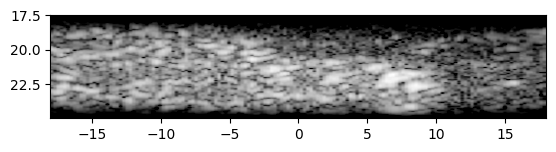

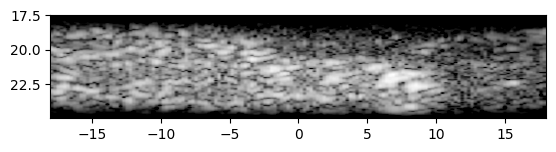

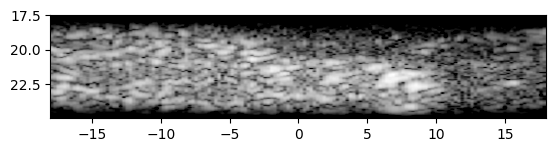

In [14]:
env = np.abs(demodall[0,0,:,:])
logged = 20 * np.log10(env/np.percentile(env, 99))

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
plt.show()

env = np.abs(demodall[0,1,:,:])
logged = 20 * np.log10(env/np.percentile(env, 99))

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
plt.show()

env = np.abs(demodall[0,2,:,:])
logged = 20 * np.log10(env/np.percentile(env, 99))

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])
plt.figure()
plt.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
plt.show()

In [15]:
from scipy.signal import butter, filtfilt

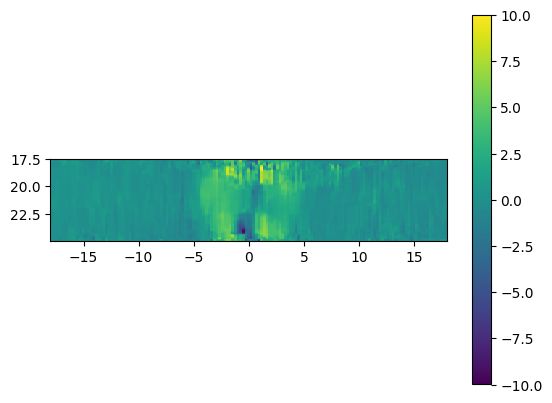

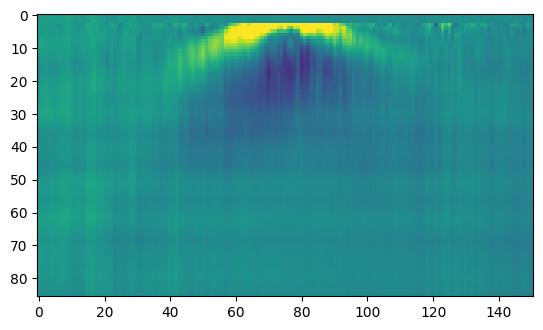

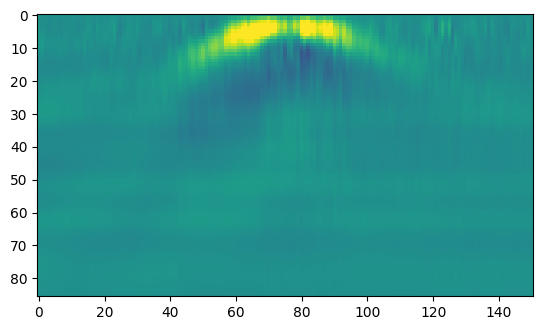

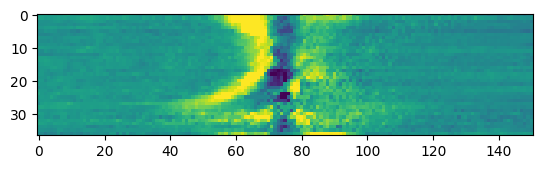

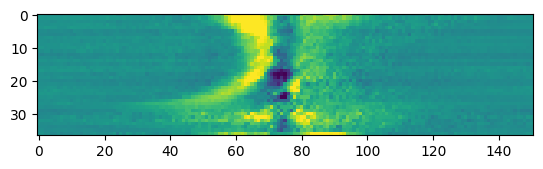

In [16]:
plt.figure()
plt.imshow(pmout[0,7,:,:], vmin=-10, vmax=10, interpolation='none',extent=ex_axlat)
plt.colorbar()
plt.show()

pmslice = np.mean(np.concatenate((pmout[:,:3,20:80,:], pmout[:,5:,20:80,:]), axis=1), axis=2)
pmslice = np.concatenate((pmslice, pmslice[:1,:,::-1]))

b, a = butter(3, (50, 350), btype='bandpass', fs=1E3/0.3)
pmfilt = filtfilt(b, a, pmslice, axis=1)

plt.figure()
plt.imshow(pmslice[0,:,:], vmin=-3, vmax=3)
plt.show()

plt.figure()
plt.imshow(pmfilt[0,:,:], vmin=-3, vmax=3)
plt.show()

plt.figure()
plt.imshow(pmslice[:,6,:], vmin=-3, vmax=3)
plt.show()

plt.figure()
plt.imshow(pmfilt[:,7,:], vmin=-3, vmax=3)
plt.show()

In [17]:
from scipy.interpolate import RegularGridInterpolator

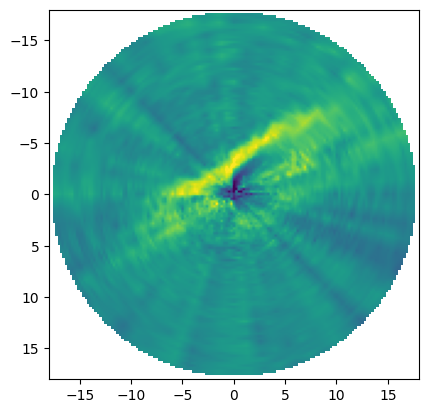

In [18]:
phis = np.radians(5*np.arange(37))
t = 0.3*(np.arange(pmslice.shape[1]) - 4)

fint = RegularGridInterpolator((phis, t, xout), pmslice, method='linear', bounds_error=False)

X, T, Y = np.meshgrid(xout, t, xout, indexing='ij')
r_out = np.hypot(X,Y)
phi_out = np.arctan2(X,Y)
r_out[phi_out<0] *= -1
phi_out[phi_out<0] += np.pi

coords = np.array((phi_out,T,r_out)).transpose(1,2,3,0)

pmint = fint(coords)

ex_xy = 1E3*np.array([xout[0], xout[-1], xout[-1], xout[0]])
plt.figure()
plt.imshow(pmint[:,10,:], vmin=-2, vmax=2, extent=ex_xy)
plt.show()

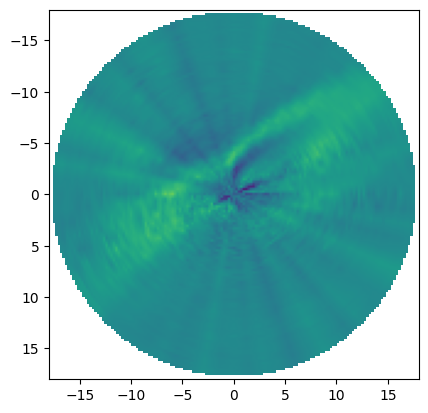

In [20]:
phis = np.radians(5*np.arange(37))
t = 0.3*(np.arange(pmslice.shape[1]) - 4)

fint = RegularGridInterpolator((phis, t, xout), pmfilt, method='linear', bounds_error=False)

X, T, Y = np.meshgrid(xout, t, xout, indexing='ij')
r_out = np.hypot(X,Y)
phi_out = np.arctan2(X,Y)
r_out[phi_out<0] *= -1
phi_out[phi_out<0] += np.pi

coords = np.array((phi_out,T,r_out)).transpose(1,2,3,0)

pmint = fint(coords)

ex_xy = 1E3*np.array([xout[0], xout[-1], xout[-1], xout[0]])
plt.figure()
plt.imshow(pmint[:,15,:], vmin=-2, vmax=2, extent=ex_xy)
plt.show()